### aim: 

### date: 

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [3]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [4]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 13})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 13}
plt.rcParams['text.usetex'] = True
plt.rc('font', **font)

CEA1/CEC1/CEC2
CNA1/CNC1/CNC2

### extract qtrB14b and Cflx

In [5]:
extract = False

def make_yearlist(yrst, yrend, dtype, tr, baseDir = '/gpfs/data/greenocean/software/runs/'):
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        ty = f'{baseDir}/TOM12_TJ_{tr}/ORCA2_1m_{yrs[i]}*{dtype}*.nc'
        t2 = glob.glob(ty)
        #print(t2)
        ylist.append(t2[0])
    return ylist

def getC14ts(yrst,yrend, tr, dtype = 'diad_T', baseDir = '/gpfs/data/greenocean/software/runs/'):
    
    tdiad = xr.open_mfdataset(make_yearlist(yrst,yrend,'diad_T',tr))
    tdiad.qtrB14b.to_netcdf(f'./GCBdata/{tr}_{yrst}_{yrend}_qtrB14b.nc')
    tdiad.Cflx.to_netcdf(f'./GCBdata/{tr}_{yrst}_{yrend}_Cflx.nc')    
    print(f'{tr} done!')
    
if extract:
    yrst = 1948; yrend = 2019
    
    getC14ts(yrst,yrend, 'CNA1', dtype = 'diad_T', baseDir = '/gpfs/data/greenocean/software/runs/')
    getC14ts(yrst,yrend, 'CNC1', dtype = 'diad_T', baseDir = '/gpfs/data/greenocean/software/runs/')
    getC14ts(yrst,yrend, 'CNC2', dtype = 'diad_T', baseDir = '/gpfs/data/greenocean/software/runs/')
    getC14ts(yrst,yrend, 'CEA1', dtype = 'diad_T', baseDir = '/gpfs/data/greenocean/software/runs/')
    getC14ts(yrst,yrend, 'CEC1', dtype = 'diad_T', baseDir = '/gpfs/data/greenocean/software/runs/')
    getC14ts(yrst,yrend, 'CEC2', dtype = 'diad_T', baseDir = '/gpfs/data/greenocean/software/runs/')


### test effect of year, forcing

In [13]:
def get_out_shit(Adir, Cdir, yrst = 1948, yrend = 2019, save = False):
    
    tmeshf = '/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc'
    tmesh = xr.open_dataset(tmeshf)
    C14d_qtr_c14 = xr.open_dataset(f'./GCBdata/{Adir}_{yrst}_{yrend}_qtrB14b.nc')   ##static
    C14d_Cflx = xr.open_dataset(f'./GCBdata/{Adir}_{yrst}_{yrend}_Cflx.nc') ###static

    C14c_qtr_c14 = xr.open_dataset(f'./GCBdata/{Cdir}_{yrst}_{yrend}_qtrB14b.nc')
    C14c_Cflx = xr.open_dataset(f'./GCBdata/{Cdir}_{yrst}_{yrend}_Cflx.nc')
    
    times = pd.date_range(f'{yrst}/01/01',f'{yrend}/12/31',freq='MS')
    
    #### -------- B) get areas/grid variables
    tmask = tmesh.tmask[0,0,:,:] 
    area = tmesh.tmask[0,0,:,:] * tmesh.e1t[0,:,:] * tmesh.e2t[0,:,:]
    tarea = np.nansum(area)
    vol = area * tmesh.e3t_0[0,0]
    tarea2 = np.nansum(vol)/10
    
    qtrnewt_C = C14c_qtr_c14.qtrB14b * tmask.values
    cflxnewt_C = C14c_Cflx.Cflx * tmask.values

    qtrnewt_D = C14d_qtr_c14.qtrB14b * tmask.values
    cflxnewt_D = C14d_Cflx.Cflx * tmask.values

    qtrnewt_C['time_counter'] = times
    qtrnewt_D['time_counter'] = times

    cflxnewt_C['time_counter'] = times
    cflxnewt_D['time_counter'] = times
    
    
    qtrflx_C = qtrnewt_C * (1/10) *2 *1e-14 *vol.values * 3.156e7
    cflxint_C = cflxnewt_C *area.values*3.156e7 

    qtrflx_D = qtrnewt_D * (1/10) *2 *1e-14 *vol.values * 3.156e7
    cflxint_D = cflxnewt_D *area.values*3.156e7 

    qtrflx_mn_C = qtrflx_C.rolling(time_counter=12, center=True).mean()\
    .sel(y=slice(0,47)).sum(dim = ['x','y'])*6.023e23*1e-26
    qtrflx_mn_D = qtrflx_D.rolling(time_counter=12, center=True).mean()\
    .sel(y=slice(0,47)).sum(dim = ['x','y'])*6.023e23*1e-26

    cflxint_mn_C = cflxint_C.rolling(time_counter=12, center=True).mean()\
    .sel(y=slice(0,47)).sum(dim = ['x','y'])*12e-15 
    cflxint_mn_D = cflxint_D.rolling(time_counter=12, center=True).mean()\
    .sel(y=slice(0,47)).sum(dim = ['x','y'])*12e-15 
    

    if save:
        try:
            qtrflx_mn_C.to_netcdf(f'./GCBdata/{Cdir}_qtrflx_mn.nc')
            cflxint_mn_C.to_netcdf(f'./GCBdata/{Cdir}_cflxint_mn.nc')
            print('saved cs')
            qtrflx_mn_D.to_netcdf(f'./GCBdata/{Adir}_qtrflx_mn.nc')
            cflxint_mn_D.to_netcdf(f'./GCBdata/{Adir}_cflxint_mn.nc')
            print('saved as')
        except:
            print('something with saving faled!')
    
    return qtrflx_mn_C, qtrflx_mn_D, cflxint_mn_C, cflxint_mn_D

Adir = 'CEA1'; Cdir = 'CEC2'
qtrflx_mn_C, qtrflx_mn_D, cflxint_mn_C, cflxint_mn_D = \
get_out_shit(Adir, Cdir, yrst = 1948, yrend = 2019, save = True)
Adir = 'CEA1'; Cdir = 'CEC1'
qtrflx_mn_C, qtrflx_mn_D, cflxint_mn_C, cflxint_mn_D = \
get_out_shit(Adir, Cdir, yrst = 1948, yrend = 2019, save = True)
Adir = 'CNA1'; Cdir = 'CNC2'
qtrflx_mn_C, qtrflx_mn_D, cflxint_mn_C, cflxint_mn_D = \
get_out_shit(Adir, Cdir, yrst = 1948, yrend = 2019, save = True)
Adir = 'CNA1'; Cdir = 'CNC1'
qtrflx_mn_C, qtrflx_mn_D, cflxint_mn_C, cflxint_mn_D = \
get_out_shit(Adir, Cdir, yrst = 1948, yrend = 2019, save = True)

saved cs
saved as
saved cs
saved as
saved cs
saved as
saved cs
saved as


In [19]:
qtrflx_C = xr.open_dataset(f'./GCBdata/CEC1_cflxint_mn.nc')
qtrflx_C

<xarray.Dataset>
Dimensions:        (time_counter: 864)
Coordinates:
    time_centered  (time_counter) object ...
  * time_counter   (time_counter) datetime64[ns] 1948-01-01 ... 2019-12-01
Data variables:
    Cflx           (time_counter) float64 ...

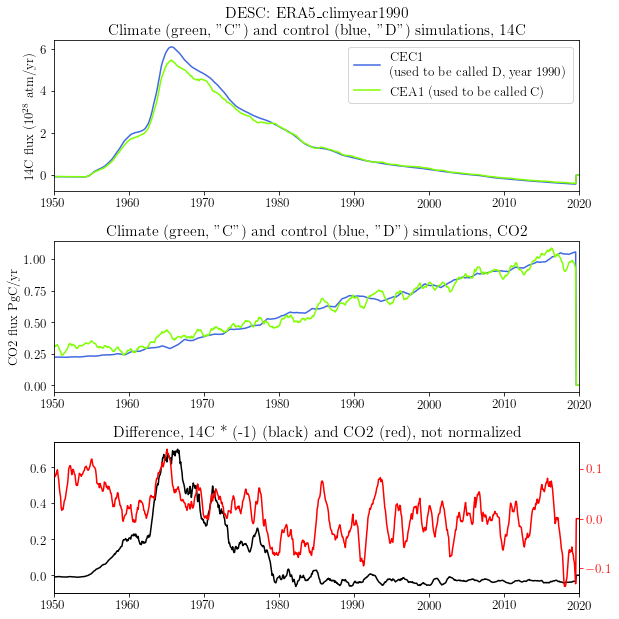

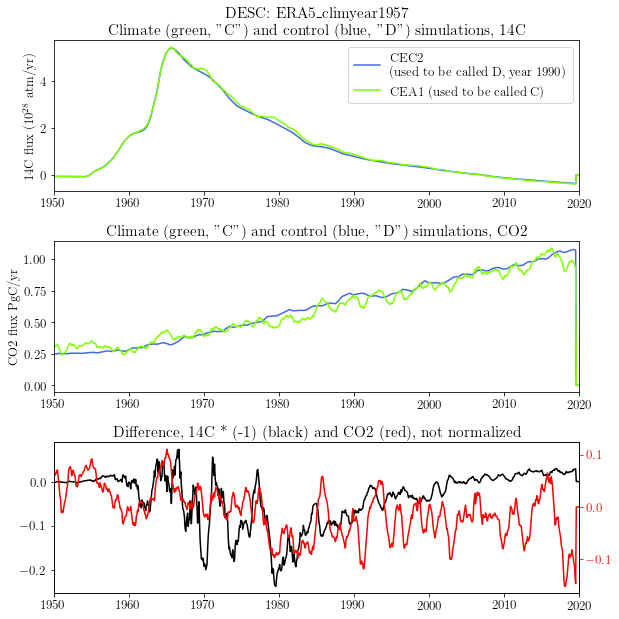

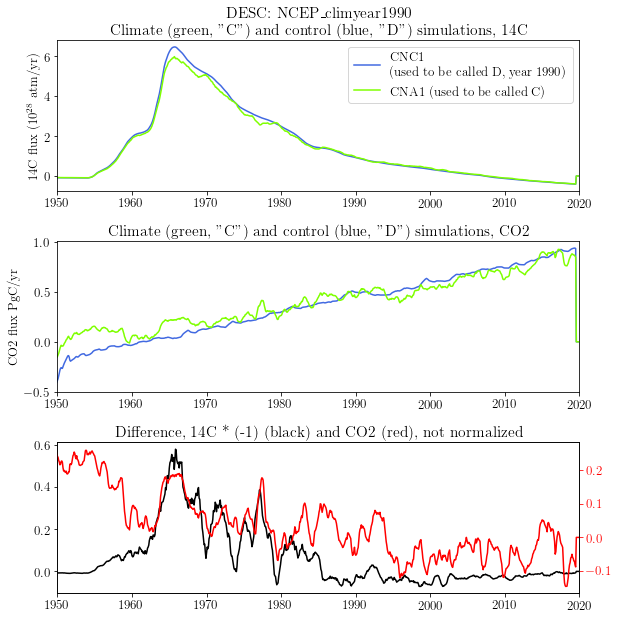

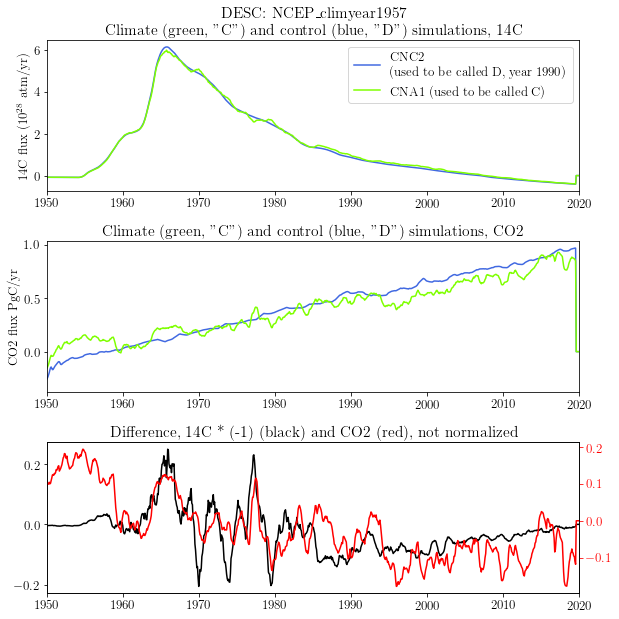

In [24]:
def plot_ts(Adir,Cdir, forc = ''):
    
    qtrflx_mn_C = xr.open_dataset(f'./GCBdata/{Cdir}_qtrflx_mn.nc')
    qtrflx_mn_D = xr.open_dataset(f'./GCBdata/{Adir}_qtrflx_mn.nc')
    cflxint_mn_C = xr.open_dataset(f'./GCBdata/{Cdir}_cflxint_mn.nc')
    cflxint_mn_D = xr.open_dataset(f'./GCBdata/{Adir}_cflxint_mn.nc')
    
    fact = 1.1
    fig, axs = plt.subplots(3,1, figsize=(8*fact, 8*fact), facecolor='w', edgecolor='k')
    axs = axs.ravel()

    axs[0].plot(qtrflx_mn_C.time_counter, qtrflx_mn_C.qtrB14b, color = 'royalblue', label = f'{Cdir} \n (used to be called D, year 1990)')

    axs[0].plot(qtrflx_mn_C.time_counter, qtrflx_mn_D.qtrB14b, color = 'chartreuse', label = f'{Adir} (used to be called C)')
    axs[0].legend()

    axs[1].plot(qtrflx_mn_C.time_counter, cflxint_mn_C.Cflx, color = 'royalblue')
    axs[1].plot(qtrflx_mn_C.time_counter, cflxint_mn_D.Cflx, color = 'chartreuse')

    ax3 = axs[2]
    ax3b = ax3.twinx()
    ax3b.tick_params(axis='y', colors='red')
    ax3.plot(qtrflx_mn_C.time_counter, (qtrflx_mn_D.qtrB14b.values-qtrflx_mn_C.qtrB14b.values)*-1, color = 'k')
    ax3b.plot(qtrflx_mn_C.time_counter, cflxint_mn_D.Cflx.values-cflxint_mn_C.Cflx.values, color = 'r')
    

    axs[0].set_xlim(pd.Timestamp('1950-01-01'), pd.Timestamp('2020-01-01'))
    axs[1].set_xlim(pd.Timestamp('1950-01-01'), pd.Timestamp('2020-01-01'))
    ax3.set_xlim(pd.Timestamp('1950-01-01'), pd.Timestamp('2020-01-01'))
    ax3b.set_xlim(pd.Timestamp('1950-01-01'), pd.Timestamp('2020-01-01'))

    axs[0].set_title(f'DESC: {forc} \n Climate (green, "C") and control (blue, "D") simulations, 14C')
    axs[1].set_title('Climate (green, "C") and control (blue, "D") simulations, CO2')
    axs[2].set_title('Difference, 14C * (-1) (black) and CO2 (red), not normalized')

    axs[0].set_ylabel('14C flux ($10^{28}$ atm/yr)')
    axs[1].set_ylabel('CO2 flux PgC/yr')


    # axs[0].set_ylim([0,7])
    # axs[1].set_ylim([0,1.3])
    # ax3.set_ylim([-0.4,0.4])
    # ax3b.set_ylim([-0.2,0.2])

    plt.tight_layout()
    plt.show()
    
    fig.savefig(f'./plt/nonnorm_{Adir}_{Cdir}_{forc}.jpg')
    

plot_ts('CEA1','CEC1', forc = 'ERA5_climyear1990')
plot_ts('CEA1','CEC2', forc = 'ERA5_climyear1957')
plot_ts('CNA1','CNC1', forc = 'NCEP_climyear1990')
plot_ts('CNA1','CNC2', forc = 'NCEP_climyear1957')

864


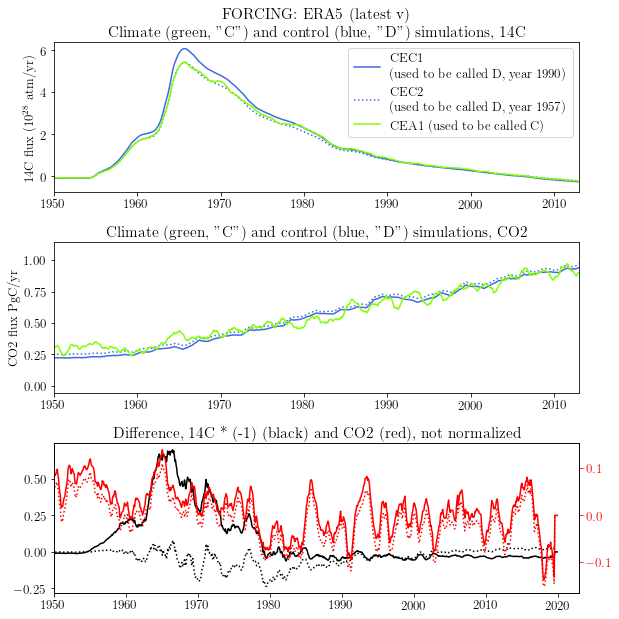

### get out graidents, etc - this is done in c14-sensitivity-analysis

### normsig

print('normsig)

In [84]:
## normsig

def make_yearlist(yrst, yrend,rnam,d):
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        yr = yrs[i]
        ty = f'/gpfs/home/mep22dku/scratch/C14/GCBdata/grad/{rnam}_dc14dz_y{yr}_d{d}.nc'
        t2 = glob.glob(ty)
        ylist.append(t2[0])
    return ylist

def get_normsig(rnam, d, yrst = 1948, yrend = 2019, normy = 1990):

    C_run = xr.open_mfdataset(make_yearlist(yrst,yrend,rnam,d))
    times = pd.date_range(f"{yrst}/01/01",f"{yrend}/12/31",freq='MS')
    C_run['time_counter'] = times
    tl = (len(times))
    print(tl)
    DC14DZ = np.squeeze(C_run.DC14DZ.values); DC14DZ[np.where(DC14DZ == 0)] = np.nan

    norm = np.squeeze(C_run.DC14DZ.sel(time_counter=slice(f'{normy}-01-01', f'{normy}-12-31')).values)
    repeats = tl // 12
    normt = np.tile(norm, repeats)
    normsig = normt/DC14DZ
    normsig[normsig > 10 ] = np.nan
    normsig[normsig < -10 ] = np.nan
    #C_run = xr.open_mfdataset(make_yearlist(1948,2019,'CEA1',5))
    C_run = C_run.assign(normsig=C_run['DDICDZ'])

    # Replace the data of the new variable "pressure"
    C_run['normsig'].data = normsig
    
    C_run.to_netcdf(f'./GCBdata/{rnam}_d{d}norm_y{normy}.nc')
    
    return C_run

# CEA1/CEC1/CEC2
# CNA1/CNC1/CNC2
extract = False
if extract:
    CEC1_d5norm = get_normsig('CEC1',5)
    CEC2_d5norm = get_normsig('CEC2',5)
    CNC1_d5norm = get_normsig('CNC1',5)
    CNC2_d5norm = get_normsig('CNC2',5)

    CEC1_d10norm = get_normsig('CEC1',10)
    CEC2_d10norm = get_normsig('CEC2',10)
    CNC1_d10norm = get_normsig('CNC1',10)
    CNC2_d10norm = get_normsig('CNC2',10)

    CEC1_d16norm = get_normsig('CEC1',16)
    CEC2_d16norm = get_normsig('CEC2',16)
    CNC1_d16norm = get_normsig('CNC1',16)
    CNC2_d16norm = get_normsig('CNC2',16)

    CEC1_d21norm = get_normsig('CEC1',21)
    CEC2_d21norm = get_normsig('CEC2',21)
    CNC1_d21norm = get_normsig('CNC1',21)
    CNC2_d21norm = get_normsig('CNC2',21)

if extract:
    CEC1_d5norm = get_normsig('CEC1',5, normy = 2010)
    CEC2_d5norm = get_normsig('CEC2',5, normy = 2010)
    CNC1_d5norm = get_normsig('CNC1',5, normy = 2010)
    CNC2_d5norm = get_normsig('CNC2',5, normy = 2010)

    CEC1_d10norm = get_normsig('CEC1',10, normy = 2010)
    CEC2_d10norm = get_normsig('CEC2',10, normy = 2010)
    CNC1_d10norm = get_normsig('CNC1',10, normy = 2010)
    CNC2_d10norm = get_normsig('CNC2',10, normy = 2010)

    CEC1_d16norm = get_normsig('CEC1',16, normy = 2010)
    CEC2_d16norm = get_normsig('CEC2',16, normy = 2010)
    CNC1_d16norm = get_normsig('CNC1',16, normy = 2010)
    CNC2_d16norm = get_normsig('CNC2',16, normy = 2010)

    CEC1_d21norm = get_normsig('CEC1',21, normy = 2010)
    CEC2_d21norm = get_normsig('CEC2',21, normy = 2010)
    CNC1_d21norm = get_normsig('CNC1',21, normy = 2010)
    CNC2_d21norm = get_normsig('CNC2',21, normy = 2010)
    
if extract:
    CEC1_d5norm = get_normsig('CEC1',5, normy = 1970)
    CEC2_d5norm = get_normsig('CEC2',5, normy = 1970)
    CNC1_d5norm = get_normsig('CNC1',5, normy = 1970)
    CNC2_d5norm = get_normsig('CNC2',5, normy = 1970)

    CEC1_d10norm = get_normsig('CEC1',10, normy = 1970)
    CEC2_d10norm = get_normsig('CEC2',10, normy = 1970)
    CNC1_d10norm = get_normsig('CNC1',10, normy = 1970)
    CNC2_d10norm = get_normsig('CNC2',10, normy = 1970)

    CEC1_d16norm = get_normsig('CEC1',16, normy = 1970)
    CEC2_d16norm = get_normsig('CEC2',16, normy = 1970)
    CNC1_d16norm = get_normsig('CNC1',16, normy = 1970)
    CNC2_d16norm = get_normsig('CNC2',16, normy = 1970)

    CEC1_d21norm = get_normsig('CEC1',21, normy = 1970)
    CEC2_d21norm = get_normsig('CEC2',21, normy = 1970)
    CNC1_d21norm = get_normsig('CNC1',21, normy = 1970)
    CNC2_d21norm = get_normsig('CNC2',21, normy = 1970)
#C_run = xr.open_mfdataset(make_yearlist(yrst,yrend,rnam,d))

In [62]:
normy = 1990
Cdir = 'CEC1'
Cnorm_d5 = xr.open_dataset(f'./GCBdata/{Cdir}_d5norm_y{normy}.nc')
Cnorm_d5.normsig.rolling(time_counter=12, center=True).mean()

<xarray.DataArray 'normsig' (time_counter: 864)>
array([       nan,        nan,        nan,        nan,        nan,
              nan, 2.45491467, 2.45621874, 2.45794012, 2.45975266,
       2.46138514, 2.46278215, 2.46387043, 2.46495208, 2.46628017,
       2.4675321 , 2.46879836, 2.46989948, 2.47086755, 2.47220509,
       2.47390416, 2.47566072, 2.47726774, 2.47866787, 2.47983684,
       2.48086659, 2.48187733, 2.4831027 , 2.48438526, 2.48551627,
       2.48652961, 2.48785921, 2.48950478, 2.49128104, 2.49288735,
       2.49427094, 2.49527173, 2.49602058, 2.49691032, 2.49806665,
       2.49928038, 2.50034849, 2.50131769, 2.50264446, 2.50441982,
       2.50622346, 2.50784549, 2.50928953, 2.51065694, 2.51192869,
       2.51329482, 2.51454719, 2.51582629, 2.51696233, 2.5179181 ,
       2.51924771, 2.52095764, 2.52276642, 2.52439917, 2.52583006,
       2.52695226, 2.52804776, 2.52929366, 2.53056805, 2.53184616,
       2.53293234, 2.53386817, 2.535174  , 2.5368871 , 2.53863928,
       2.54022923, 2.54161651, 2.54267668, 2.54347131, 2.54384217,
       2.54234489, 2.53530216, 2.52260676, 2.50469448, 2.47291983,
       2.42719691, 2.37676246, 2.32971476, 2.28763769, 2.25820708,
       2.23995449, 2.22259391, 2.19889715, 2.16576591, 2.13088   ,
       2.09746162, 2.05474669, 2.00685346, 1.96017629, 1.91857069,
       1.88283442, 1.85602306, 1.83767265, 1.82060261, 1.80080653,
...
       3.8781869 , 3.91957494, 3.93917222, 3.94619082, 3.9504344 ,
       3.95492362, 3.9608371 , 3.96844847, 3.97822204, 3.99196016,
       4.0343835 ,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan])
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 1948-01-01 ... 2019-12-01
Attributes:
    units:      
    long_name:  DDICDZ (lev5-lev0, y = slice(0,47), mean, python indexing)

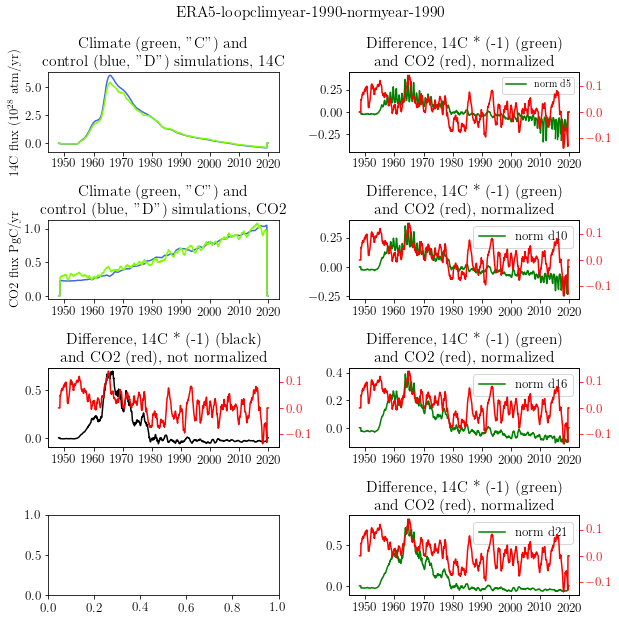

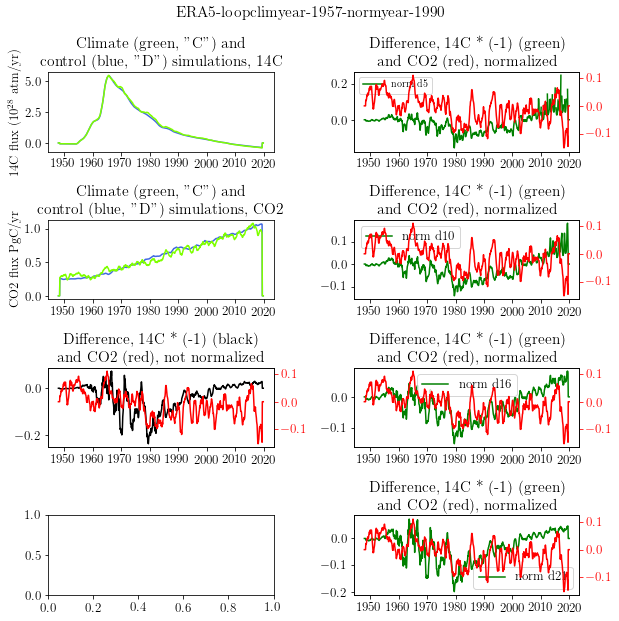

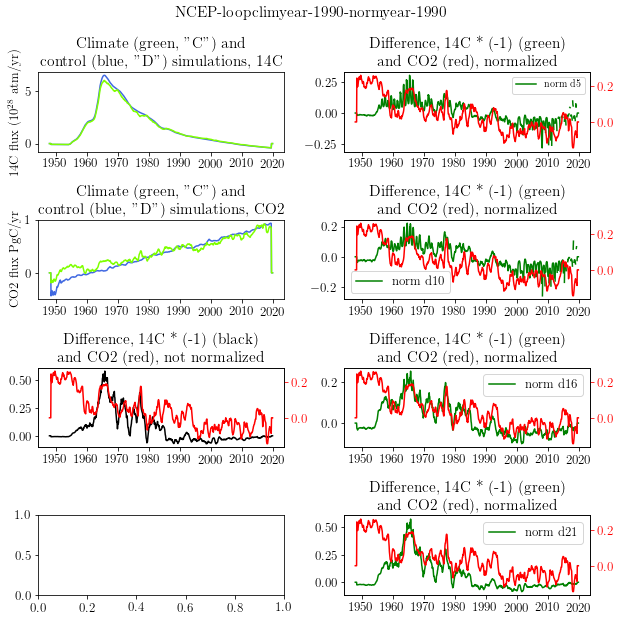

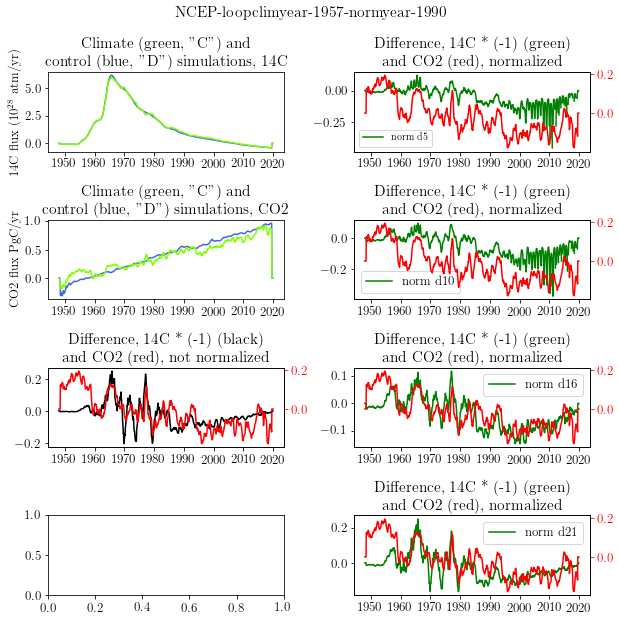

In [65]:
def plot_ts_norm(Adir,Cdir, forc = '', normy = 1990):
    
    qtrflx_mn_C = xr.open_dataset(f'./GCBdata/{Cdir}_qtrflx_mn.nc')
    qtrflx_mn_D = xr.open_dataset(f'./GCBdata/{Adir}_qtrflx_mn.nc')
    cflxint_mn_C = xr.open_dataset(f'./GCBdata/{Cdir}_cflxint_mn.nc')
    cflxint_mn_D = xr.open_dataset(f'./GCBdata/{Adir}_cflxint_mn.nc')
    
    Cnorm_d5 = xr.open_dataset(f'./GCBdata/{Cdir}_d5norm_y{normy}.nc')
    Cnorm_d10 = xr.open_dataset(f'./GCBdata/{Cdir}_d10norm_y{normy}.nc')
    Cnorm_d16 = xr.open_dataset(f'./GCBdata/{Cdir}_d16norm_y{normy}.nc')
    Cnorm_d21 = xr.open_dataset(f'./GCBdata/{Cdir}_d21norm_y{normy}.nc')
    
    fact = 1.1
    fig, axs = plt.subplots(4,2, figsize=(8*fact, 8*fact), facecolor='w', edgecolor='k')
    axs = axs.ravel()

    axs[0].plot(qtrflx_mn_C.time_counter, qtrflx_mn_C.qtrB14b, color = 'royalblue', label = f'{Cdir} \n (used to be called D, year 1990)')

    axs[0].plot(qtrflx_mn_C.time_counter, qtrflx_mn_D.qtrB14b, color = 'chartreuse', label = f'{Adir} (used to be called C)')
    # axs[0].legend()

    axs[2].plot(qtrflx_mn_C.time_counter, cflxint_mn_C.Cflx, color = 'royalblue')
    axs[2].plot(qtrflx_mn_C.time_counter, cflxint_mn_D.Cflx, color = 'chartreuse')

    ax3 = axs[4]
    ax3b = ax3.twinx()
    ax3b.tick_params(axis='y', colors='red')
    ax3.plot(qtrflx_mn_C.time_counter, (qtrflx_mn_D.qtrB14b.values-qtrflx_mn_C.qtrB14b.values)*-1, color = 'k')
    ax3b.plot(qtrflx_mn_C.time_counter, cflxint_mn_D.Cflx.values-cflxint_mn_C.Cflx.values, color = 'r')    
    
    ax4 = axs[1]
    ax4b = ax4.twinx()
    ax4b.tick_params(axis='y', colors='red')
    ax4b.plot(qtrflx_mn_C.time_counter, cflxint_mn_D.Cflx.values-cflxint_mn_C.Cflx.values, color = 'r')
    ax4.plot(qtrflx_mn_C.time_counter, (qtrflx_mn_D.qtrB14b.values-qtrflx_mn_C.qtrB14b.values)
             *-1*Cnorm_d5.normsig.values, color = 'g', label = 'norm d5')   
    
    ax5 = axs[3]
    ax5b = ax5.twinx()
    ax5b.tick_params(axis='y', colors='red')
    ax5b.plot(qtrflx_mn_C.time_counter, cflxint_mn_D.Cflx.values-cflxint_mn_C.Cflx.values, color = 'r')
    ax5.plot(qtrflx_mn_C.time_counter, (qtrflx_mn_D.qtrB14b.values-qtrflx_mn_C.qtrB14b.values)
             *-1*Cnorm_d10.normsig.values, color = 'g', label = 'norm d10')    

    ax6 = axs[5]
    ax6b = ax6.twinx()
    ax6b.tick_params(axis='y', colors='red')
    ax6b.plot(qtrflx_mn_C.time_counter, cflxint_mn_D.Cflx.values-cflxint_mn_C.Cflx.values, color = 'r')
    ax6.plot(qtrflx_mn_C.time_counter, (qtrflx_mn_D.qtrB14b.values-qtrflx_mn_C.qtrB14b.values)
             *-1*Cnorm_d16.normsig.values, color = 'g', label = 'norm d16')    
    
    ax7 = axs[7]
    ax7b = ax7.twinx()
    ax7b.tick_params(axis='y', colors='red')
    ax7b.plot(qtrflx_mn_C.time_counter, cflxint_mn_D.Cflx.values-cflxint_mn_C.Cflx.values, color = 'r')
    ax7.plot(qtrflx_mn_C.time_counter, (qtrflx_mn_D.qtrB14b.values-qtrflx_mn_C.qtrB14b.values)
             *-1*Cnorm_d21.normsig.values, color = 'g', label = 'norm d21')        


    
    #*-1*d10norm,
    
    # axs[0].set_xlim(pd.Timestamp('1950-01-01'), pd.Timestamp('2020-01-01'))
    # axs[1].set_xlim(pd.Timestamp('1950-01-01'), pd.Timestamp('2020-01-01'))
    # ax3.set_xlim(pd.Timestamp('1950-01-01'), pd.Timestamp('2020-01-01'))
    # ax3b.set_xlim(pd.Timestamp('1950-01-01'), pd.Timestamp('2020-01-01'))

    axs[0].set_title(f'Climate (green, "C") and \n control (blue, "D") simulations, 14C')
    axs[2].set_title('Climate (green, "C") and \n control (blue, "D") simulations, CO2')
    axs[4].set_title('Difference, 14C * (-1) (black) \n and CO2 (red), not normalized')
    
    for i in [1,3,5,7]:
        axs[i].set_title('Difference, 14C * (-1) (green) \n and CO2 (red), normalized')
        axs[i].legend()
        
    axs[0].set_ylabel('14C flux ($10^{28}$ atm/yr)')
    axs[2].set_ylabel('CO2 flux PgC/yr')
    ax4.legend(ncol = 2, fontsize = 10, loc = 'best')

    # axs[0].set_ylim([0,7])
    # axs[1].set_ylim([0,1.3])
    # ax3.set_ylim([-0.4,0.4])
    # ax3b.set_ylim([-0.2,0.2])

    plt.suptitle(forc)
    
    plt.tight_layout()
    plt.show()
    
    fig.savefig(f'./plt/norm_{Adir}_{Cdir}_{forc}_{normy}.jpg')
           
Adir = 'CEA1'; Cdir = 'CEC1'
plot_ts_norm(Adir,Cdir, forc = 'ERA5-loopclimyear-1990-normyear-1990', normy = 1990)
Adir = 'CEA1'; Cdir = 'CEC2'
plot_ts_norm(Adir,Cdir, forc = 'ERA5-loopclimyear-1957-normyear-1990', normy = 1990)
Adir = 'CNA1'; Cdir = 'CNC1'
plot_ts_norm(Adir,Cdir, forc = 'NCEP-loopclimyear-1990-normyear-1990', normy = 1990)
Adir = 'CNA1'; Cdir = 'CNC2'
plot_ts_norm(Adir,Cdir, forc = 'NCEP-loopclimyear-1957-normyear-1990', normy = 1990)

In [88]:
from scipy.stats import pearsonr

def get_correlations_pvalues(Adir, Cdir, yrst = 1959, yrend = 2015, normy = 1990, desc = ''):
    
    print(f'{desc}')
    print(f'corr for {Adir}, {Cdir}, {yrst}-{yrend} normalized to {normy}:')
    
    qtrflx_mn_C = xr.open_dataset(f'./GCBdata/{Cdir}_qtrflx_mn.nc')
    qtrflx_mn_D = xr.open_dataset(f'./GCBdata/{Adir}_qtrflx_mn.nc')
    cflxint_mn_C = xr.open_dataset(f'./GCBdata/{Cdir}_cflxint_mn.nc')
    cflxint_mn_D = xr.open_dataset(f'./GCBdata/{Adir}_cflxint_mn.nc')
    
    Cnorm_d5 = xr.open_dataset(f'./GCBdata/{Cdir}_d5norm_y{normy}.nc')
    Cnorm_d10 = xr.open_dataset(f'./GCBdata/{Cdir}_d10norm_y{normy}.nc')
    Cnorm_d16 = xr.open_dataset(f'./GCBdata/{Cdir}_d16norm_y{normy}.nc')
    Cnorm_d21 = xr.open_dataset(f'./GCBdata/{Cdir}_d21norm_y{normy}.nc')
    
    
    rs = np.zeros(5); ps = np.zeros(5)
    
    x = (qtrflx_mn_D.qtrB14b-qtrflx_mn_C.qtrB14b)*-1
    y = (cflxint_mn_D.Cflx-cflxint_mn_C.Cflx)   
    xa = x.sel(time_counter=slice(f'{yrst}-01-01', f'{yrend}-12-31')).values
    ya = y.sel(time_counter=slice(f'{yrst}-01-01', f'{yrend}-12-31')).values
    r_value, p_value = pearsonr(xa, ya)
    rs[0] = r_value; ps[0] = p_value
    print(f'not norm: {r_value}, {p_value}')
    
    try:
        x = (qtrflx_mn_D.qtrB14b-qtrflx_mn_C.qtrB14b)*-1*Cnorm_d5.normsig.values
        y = (cflxint_mn_D.Cflx-cflxint_mn_C.Cflx)   
        xa = x.sel(time_counter=slice(f'{yrst}-01-01', f'{yrend}-12-31')).values
        ya = y.sel(time_counter=slice(f'{yrst}-01-01', f'{yrend}-12-31')).values
        r_value, p_value = pearsonr(xa, ya)
        rs[1] = r_value; ps[1] = p_value
        print(f'normd5: {r_value}, {p_value}')
    except:
        print('normd5 doesnt work')
        
    try:
        x = (qtrflx_mn_D.qtrB14b-qtrflx_mn_C.qtrB14b)*-1*Cnorm_d10.normsig.values
        y = (cflxint_mn_D.Cflx-cflxint_mn_C.Cflx)   
        xa = x.sel(time_counter=slice(f'{yrst}-01-01', f'{yrend}-12-31')).values
        ya = y.sel(time_counter=slice(f'{yrst}-01-01', f'{yrend}-12-31')).values
        r_value, p_value = pearsonr(xa, ya)
        rs[2] = r_value; ps[2] = p_value
        print(f'normd10: {r_value}, {p_value}')
    except:
        print('normd10 doesnt work')

    try:
        x = (qtrflx_mn_D.qtrB14b-qtrflx_mn_C.qtrB14b)*-1*Cnorm_d16.normsig.values
        y = (cflxint_mn_D.Cflx-cflxint_mn_C.Cflx)   
        xa = x.sel(time_counter=slice(f'{yrst}-01-01', f'{yrend}-12-31')).values
        ya = y.sel(time_counter=slice(f'{yrst}-01-01', f'{yrend}-12-31')).values
        r_value, p_value = pearsonr(xa, ya)
        rs[3] = r_value; ps[3] = p_value
        print(f'normd16: {r_value}, {p_value}')
    except:
        print('normd16 doesnt work')
        
    try:
        x = (qtrflx_mn_D.qtrB14b-qtrflx_mn_C.qtrB14b)*-1*Cnorm_d21.normsig.values
        y = (cflxint_mn_D.Cflx-cflxint_mn_C.Cflx)   
        xa = x.sel(time_counter=slice(f'{yrst}-01-01', f'{yrend}-12-31')).values
        ya = y.sel(time_counter=slice(f'{yrst}-01-01', f'{yrend}-12-31')).values
        r_value, p_value = pearsonr(xa, ya)
        rs[4] = r_value; ps[4] = p_value
        print(f'normd21: {r_value}, {p_value}')
    except:
        print('normd21 doesnt work')
    print('-----')
    
    savenam = f'./GCBdata/pearsonr_{Adir}_{Cdir}_{normy}.nc'
    data_vars = {'r':(['din'], rs,),\
                 'p':(['din'], ps,),
    }
    # define coordinates
    coords = {'din': (['din'], [0,5,10,16,21]),}
    # define global attributes
    attrs = {'made in':'C14/C14-sens-anal-refactor.ipynb',
    'desc': ''
    }
    ds = xr.Dataset(data_vars=data_vars,
    coords=coords,
    attrs=attrs)
    ds.to_netcdf(savenam)
    
    
    return rs, ps

x, y = get_correlations_pvalues('CEA1', 'CEC1', desc = 'ERA5, loop year 1990')
x, y = get_correlations_pvalues('CEA1', 'CEC2', desc = 'ERA5, loop year 1957')
x, y = get_correlations_pvalues('CNA1', 'CNC1', desc = 'NCEP, loop year 1990')
x, y = get_correlations_pvalues('CNA1', 'CNC2', desc = 'NCEP, loop year 1957')

ERA5, loop year 1990
corr for CEA1, CEC1, 1959-2015 normalized to 1990:
not norm: 0.5697934331427352, 3.9266722110094584e-60
normd5 doesnt work
normd10: 0.4460682889283822, 9.460696682882858e-35
normd16: 0.4946926223168099, 1.6721797145354727e-43
normd21: 0.5560210740149998, 9.251886587912989e-57
-----
ERA5, loop year 1957
corr for CEA1, CEC2, 1959-2015 normalized to 1990:
not norm: 0.29966437249423894, 1.1692432353517681e-15
normd5 doesnt work
normd10: 0.296882658614159, 2.1957446915700127e-15
normd16: 0.31611843655769545, 2.4410001781702726e-17
normd21: 0.3025394635455051, 6.052132067243377e-16
-----
NCEP, loop year 1990
corr for CNA1, CNC1, 1959-2015 normalized to 1990:
not norm: 0.7694365089776691, 6.631058297295358e-135
normd5 doesnt work
normd10 doesnt work
normd16: 0.7807481041917643, 2.0375400213571474e-141
normd21: 0.7791118370117276, 1.883605525289524e-140
-----
NCEP, loop year 1957
corr for CNA1, CNC2, 1959-2015 normalized to 1990:
not norm: 0.6096738875942347, 7.46726515734

In [89]:
x, y = get_correlations_pvalues('CEA1', 'CEC1', normy = 1970, desc = 'ERA5, loop year 1990')
x, y = get_correlations_pvalues('CEA1', 'CEC2', normy = 1970, desc = 'ERA5, loop year 1957')
x, y = get_correlations_pvalues('CNA1', 'CNC1', normy = 1970, desc = 'NCEP, loop year 1990')
x, y = get_correlations_pvalues('CNA1', 'CNC2', normy = 1970, desc = 'NCEP, loop year 1957')



ERA5, loop year 1990
corr for CEA1, CEC1, 1959-2015 normalized to 1970:
not norm: 0.5697934331427352, 3.9266722110094584e-60
normd5 doesnt work
normd10 doesnt work
normd16: 0.49711425009105253, 5.616895789004938e-44
normd21: 0.5572737963484874, 4.634373286961617e-57
-----
ERA5, loop year 1957
corr for CEA1, CEC2, 1959-2015 normalized to 1970:
not norm: 0.29966437249423894, 1.1692432353517681e-15
normd5 doesnt work
normd10 doesnt work
normd16: 0.3183967629525717, 1.4011457808386116e-17
normd21: 0.3040239280873738, 4.2952710816262874e-16
-----
NCEP, loop year 1990
corr for CNA1, CNC1, 1959-2015 normalized to 1970:
not norm: 0.7694365089776691, 6.631058297295358e-135
normd5 doesnt work
normd10 doesnt work
normd16: 0.784309674759585, 1.5052553070076006e-143
normd21: 0.7805641610471921, 2.6188018547814403e-141
-----
NCEP, loop year 1957
corr for CNA1, CNC2, 1959-2015 normalized to 1970:
not norm: 0.6096738875942347, 7.46726515734389e-71
normd5 doesnt work
normd10 doesnt work
normd16: 0.7057

In [90]:
x, y = get_correlations_pvalues('CEA1', 'CEC1', normy = 2010, desc = 'ERA5, loop year 2010')
x, y = get_correlations_pvalues('CEA1', 'CEC2', normy = 2010, desc = 'ERA5, loop year 1957')
x, y = get_correlations_pvalues('CNA1', 'CNC1', normy = 2010, desc = 'NCEP, loop year 2010')
x, y = get_correlations_pvalues('CNA1', 'CNC2', normy = 2010, desc = 'NCEP, loop year 1957')

ERA5, loop year 2010
corr for CEA1, CEC1, 1959-2015 normalized to 2010:
not norm: 0.5697934331427352, 3.9266722110094584e-60
normd5: 0.3676494575901986, 2.5676223945013027e-23
normd10: 0.42753392500319803, 9.073314520554562e-32
normd16: 0.48953703948033556, 1.6573383027384604e-42
normd21: 0.5553070593990601, 1.3702123415330916e-56
-----
ERA5, loop year 1957
corr for CEA1, CEC2, 1959-2015 normalized to 2010:
not norm: 0.29966437249423894, 1.1692432353517681e-15
normd5 doesnt work
normd10: 0.2822888290763957, 5.360128943429078e-14
normd16: 0.3116918391320711, 7.080680427437987e-17
normd21: 0.30173404029517226, 7.283650089052382e-16
-----
NCEP, loop year 2010
corr for CNA1, CNC1, 1959-2015 normalized to 2010:
not norm: 0.7694365089776691, 6.631058297295358e-135
normd5 doesnt work
normd10 doesnt work
normd16: 0.770652780756029, 1.378365879980016e-135
normd21: 0.7782701057457724, 5.870030086675949e-140
-----
NCEP, loop year 1957
corr for CNA1, CNC2, 1959-2015 normalized to 2010:
not norm: 0

## plot gradient

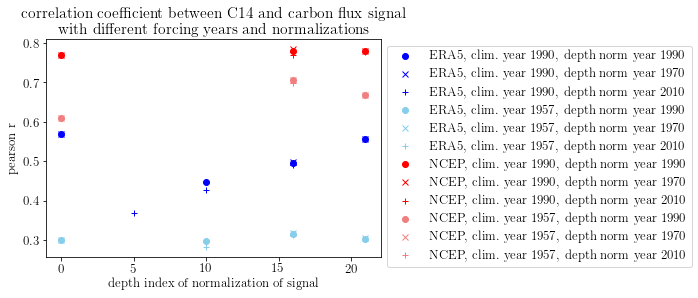

In [102]:
plt.figure()


w = xr.open_dataset(f'./GCBdata/pearsonr_CEA1_CEC1_1990.nc')
lab = 'ERA5, clim. year 1990, depth norm year 1990'
wr = w.r.values; wr[wr == 0] = np.nan
plt.plot(w.din, w.r, marker = 'o', color = 'b', linestyle = '', label = lab)

w = xr.open_dataset(f'./GCBdata/pearsonr_CEA1_CEC1_1970.nc')
lab = 'ERA5, clim. year 1990, depth norm year 1970'
wr = w.r.values; wr[wr == 0] = np.nan
plt.plot(w.din, w.r, marker = 'x', color = 'b', linestyle = '', label = lab)

w = xr.open_dataset(f'./GCBdata/pearsonr_CEA1_CEC1_2010.nc')
lab = 'ERA5, clim. year 1990, depth norm year 2010'
wr = w.r.values; wr[wr == 0] = np.nan
plt.plot(w.din, w.r, marker = '+', color = 'b', linestyle = '', label = lab)

w = xr.open_dataset(f'./GCBdata/pearsonr_CEA1_CEC2_1990.nc')
lab = 'ERA5, clim. year 1957, depth norm year 1990'
wr = w.r.values; wr[wr == 0] = np.nan
plt.plot(w.din, w.r, marker = 'o', color = 'skyblue', linestyle = '', label = lab)

w = xr.open_dataset(f'./GCBdata/pearsonr_CEA1_CEC2_1970.nc')
lab = 'ERA5, clim. year 1957, depth norm year 1970'
wr = w.r.values; wr[wr == 0] = np.nan
plt.plot(w.din, w.r, marker = 'x', color = 'skyblue', linestyle = '', label = lab)

w = xr.open_dataset(f'./GCBdata/pearsonr_CEA1_CEC2_2010.nc')
lab = 'ERA5, clim. year 1957, depth norm year 2010'
wr = w.r.values; wr[wr == 0] = np.nan
plt.plot(w.din, w.r, marker = '+', color = 'skyblue', linestyle = '', label = lab)

###

w = xr.open_dataset(f'./GCBdata/pearsonr_CNA1_CNC1_1990.nc')
lab = 'NCEP, clim. year 1990, depth norm year 1990'
wr = w.r.values; wr[wr == 0] = np.nan
plt.plot(w.din, w.r, marker = 'o', color = 'r', linestyle = '', label = lab)

w = xr.open_dataset(f'./GCBdata/pearsonr_CNA1_CNC1_1970.nc')
lab = 'NCEP, clim. year 1990, depth norm year 1970'
wr = w.r.values; wr[wr == 0] = np.nan
plt.plot(w.din, w.r, marker = 'x', color = 'r', linestyle = '', label = lab)

w = xr.open_dataset(f'./GCBdata/pearsonr_CNA1_CNC1_2010.nc')
lab = 'NCEP, clim. year 1990, depth norm year 2010'
wr = w.r.values; wr[wr == 0] = np.nan
plt.plot(w.din, w.r, marker = '+', color = 'r', linestyle = '', label = lab)

w = xr.open_dataset(f'./GCBdata/pearsonr_CNA1_CNC2_1990.nc')
lab = 'NCEP, clim. year 1957, depth norm year 1990'
wr = w.r.values; wr[wr == 0] = np.nan
plt.plot(w.din, w.r, marker = 'o', color = 'lightcoral', linestyle = '', label = lab)

w = xr.open_dataset(f'./GCBdata/pearsonr_CNA1_CNC2_1970.nc')
lab = 'NCEP, clim. year 1957, depth norm year 1970'
wr = w.r.values; wr[wr == 0] = np.nan
plt.plot(w.din, w.r, marker = 'x', color = 'lightcoral', linestyle = '', label = lab)

w = xr.open_dataset(f'./GCBdata/pearsonr_CNA1_CNC2_2010.nc')
lab = 'NCEP, clim. year 1957, depth norm year 2010'
wr = w.r.values; wr[wr == 0] = np.nan
plt.plot(w.din, w.r, marker = '+', color = 'lightcoral', linestyle = '', label = lab)



plt.legend(bbox_to_anchor = [1,1])


plt.title('correlation coefficient between C14 and carbon flux signal \n with different forcing years and normalizations')
plt.xlabel('depth index of normalization of signal')
plt.ylabel('pearson r')

plt.savefig(f'./plt/pearsonrsummary.jpg')


In [92]:
w

<xarray.Dataset>
Dimensions:  (din: 5)
Coordinates:
  * din      (din) int64 0 5 10 16 21
Data variables:
    r        (din) float64 ...
    p        (din) float64 ...
Attributes:
    made in:  C14/C14-sens-anal-refactor.ipynb
    desc: